# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Для начала необходимо обновить и импортировать библиотеки<br>
Ячейки с библиотеками разбиты на ячейки соответственно их направлению использования для более удобной проверки импортируемых частей

### Установка библиотек

Моделирование

In [1]:
!pip install scikit-learn==1.4.0

Визуализация

In [2]:
!pip install matplotlib==3.8.4
!pip install seaborn==0.13.2

### Импорт библиотек

<i>Работа с данными, визуализация<i>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Настройка pandas

In [4]:
pd.option_context("display.max_rows", None, "display.max_columns", None);

<i>Библиотека sklearn<i>

In [5]:
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import StandardScaler

# загружаем функцию для работы с метриками
from sklearn.metrics import mean_squared_error

# загружаем нужные модели
from sklearn.linear_model import LinearRegression

Далее необходимо выгрузить данные и проверить их на корректность

### Загрузка данных

In [6]:
# Регион-1
df_geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
# Регион-2
df_geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
# Регион-3
df_geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

### Исследование датафреймов на соответствие данных

In [7]:
df_geo_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Текстовых данных, кроме id нет.

Далее рассмотрим общее описание датафреймов

In [8]:
def check_df(data):
    display(data.head())
    display(data.describe())
    display(data.info())
    data.hist(bins=20)

df_geo_0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

''

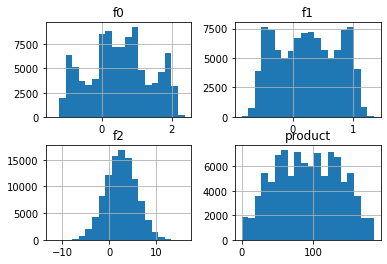

In [9]:
check_df(df_geo_0)
;

Величины "f2", "product" похожи на нормальное распределение<br>
"f0", f1" похожи на нормальные распределения с 4 и 3 вершинами соотвественно<br>
Выбивающихся значений не обнаружено

df_geo_1

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

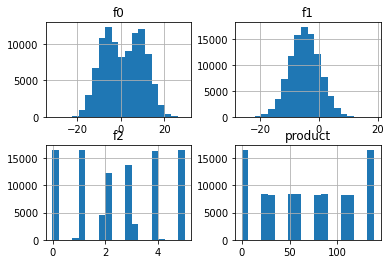

In [10]:
check_df(df_geo_1)

Величина "f1" похожа на нормальное распределение<br>
"f0" похожа на нормальные распределения с 2 вершинами<br>
"f2", "product" похоже на бета распределение<br>
Выбивающихся значений не обнаружено

df_geo_2

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

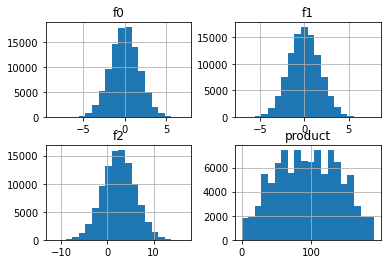

In [11]:
check_df(df_geo_2)

Распределение всех величит похоже на нормальное.<br>
Выбивающихся значений не обнаружено

### Вывод

- Данные загружены и проверены на соответствие заявленным<br>
- Явно выделяющихся значений не обнаружено

## Обучение и проверка модели

### Подготовка переменных и констант

Константы для моделей

In [12]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Выделим целевой признак и уберем его из переменных с использумыми столбцами. В нашем случае числовыми.

Название столбца с целевым признаком

In [13]:
target_column = 'product'

Поскольку явно не указано значение параметров "f*", то обучим модель с маштабированием и без после чего выделим лучшую. Далее выделим переменную с названием столбцов для мастабирования без 'id' на примере Регион-1.

In [14]:
drop_column = 'id'

In [15]:
df_geo_0.head(1)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.22117,105.280062


In [16]:
num_columns = list(df_geo_0.select_dtypes(include='number').columns)
num_columns

['f0', 'f1', 'f2', 'product']

In [17]:
num_columns = [x for x in num_columns if x != target_column]
num_columns

['f0', 'f1', 'f2']

По ТЗ все признаки значимы, следовательно строить матрицу корреляции стоит только для проверки

В предоставленных данных нет пропусков, поэтому для нашего случая SimpleImputer не нужен

### Обучение модели

In [18]:
# создаём объект для работы с моделью
model_lr = LinearRegression()

Далее обучим и выделим основные данные для работы по всем регионам

Функция для обучения и предсказания выборки

In [19]:
def model_lin_reg(data, target_name=target_column, to_drop=drop_column):
    data = data.drop(to_drop, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
        data.drop(target_name, axis=1),
        data[target_name],
        test_size = TEST_SIZE, 
        random_state = RANDOM_STATE
    )
    model_out = model_lr.fit(X_train, y_train)
    predicted = model_out.predict(X_test)
    return X_train, X_test, y_train, y_test, model_out, predicted

### Предсказание модели

In [20]:
X_train_0, X_test_0, y_train_0, y_test_0, model_geo_0, predicted_0 = model_lin_reg(df_geo_0)

In [21]:
X_train_1, X_test_1, y_train_1, y_test_1, model_geo_1, predicted_1 = model_lin_reg(df_geo_1)

In [22]:
X_train_2, X_test_2, y_train_2, y_test_2, model_geo_2, predicted_2 = model_lin_reg(df_geo_2)

### Средний предсказанный запас сырья и RMSE модели

Далее исследуем RMSE и предсказанный запас сырья

Средний запас сырья по регионам

In [23]:
mean_predicted_0 = predicted_0.mean()
mean_predicted_1 = predicted_1.mean()
mean_predicted_2 = predicted_2.mean()

RMSE по регионам

In [24]:
RMSE_0 = mean_squared_error(y_test_0, predicted_0, squared=False)
RMSE_1 = mean_squared_error(y_test_1, predicted_1, squared=False)
RMSE_2 = mean_squared_error(y_test_2, predicted_2, squared=False)

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [25]:
RMSE_0, RMSE_1, RMSE_2

(37.75660035026169, 0.890280100102884, 40.145872311342174)

Далее выделим результат расчетов в датафрейм и проанализируем

In [26]:
metrics_out = [[1, mean_predicted_0, RMSE_0],
               [2, mean_predicted_1, RMSE_1],
               [3, mean_predicted_2, RMSE_2]]

columns_out = ['region', 'mean_product', 'RMSE']


df_metrics_model = pd.DataFrame(metrics_out, columns=columns_out)

In [27]:
df_metrics_model_print = df_metrics_model
df_metrics_model_print[['mean_product', 'RMSE']] = round(df_metrics_model_print[['mean_product', 'RMSE']], 1)
display(df_metrics_model_print)

,region,mean_product,RMSE
0,1,92.4,37.8
1,2,68.7,0.9
2,3,94.8,40.1


''

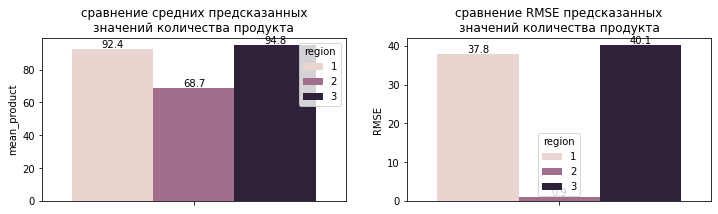

In [28]:
plt.figure(figsize=(12, 3))
    
plt.subplot(1, 2, 1)
ax = sns.barplot(
        data=df_metrics_model_print.sort_values(by='mean_product', ascending=False),
        y='mean_product',
        hue='region'
)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('сравнение средних предсказанных\nзначений количества продукта')

plt.subplot(1, 2, 2)
ax = sns.barplot(
        data=df_metrics_model_print.sort_values(by='RMSE', ascending=False),
        y='RMSE',
        hue='region'
)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('сравнение RMSE предсказанных\nзначений количества продукта')
;

### Вывод

- RMSE для 1 и 3 моделей достаточно большое (около 40-45% от среднего значения), что является высоким отклонением, что говорит о не лучшей предсказательной способности для этих регионов.<br>
- В свою очередь, для второго региона RMSE составляет около 1.5% от среднего, что позволяет говорит о удовлетворительной точности модели<br>
- Получены модели линейной регрессии для каждого из регионов;
- По модели наибольший средний запас сырья в Регион-1, Регион-3. По предсказаниям вероятнее всего лучше всего подойдут эти регионы, но это необходимо проверить далее, т.к. высокий RMSE

## Подготовка к расчёту прибыли

### Основные константы для разработки

Для начала определим константы с данными из ТЗ

In [29]:
TOTAL_BUDGET = 10**10
REVENUE_UNIT = 4.5*10**5
TOP_POINT = 200
TOTAL_POINT = 500
MAX_PART_LOSS = 0.025  #  Половина остаточного значения
                       #  для доверительного интервала: (100 - 95) * 0.5

### Расчет точки безубыточности

Поскольку бюджет на 200 точек, то найдем количество добываемого ресурса необходимого с одной точки с учетом цены для выхода в "0"

In [30]:
break_even_point = TOTAL_BUDGET / (REVENUE_UNIT * TOP_POINT)
break_even_point

111.11111111111111

Средний запас ссырья наибольший  в регионах 1 и 2,
но стоит посмотреть детально точки всех регионов,
т.к. во втором регионе с учетом отклонения значение ближе к предсказанным<br>
Также, что ярко выражено - во всех регионах средний запас скважин меньше необходимого для точки безубыточности

### Вывод

- Определены основные константы для расчетов, в том числе точка безубыточности

## Функция для расчета прибыли

### Функция

Далее напишем функцию для расчета прибыли по для регионов по предсказаниям модели для 200 лучших источников

In [31]:
num_columns

['f0', 'f1', 'f2']

In [32]:
def check_top_200(data, model,
                  model_columns=num_columns, check_point=break_even_point, print_check=True):
    
    divide = 10**9
    
    predicted = model.predict(data[num_columns])
    data['predicted'] = predicted
    data = data.sort_values(by='predicted', ascending=False)
    top_ = data.head(TOP_POINT)
    sum_top = top_['predicted'].sum()
    avg_top = sum_top / TOP_POINT
    revenue_top = sum_top * REVENUE_UNIT
    revenue_itog = revenue_top - TOTAL_BUDGET
    
    if print_check:
        if revenue_top >= TOTAL_BUDGET:
            print("Больше точки безубыточности")
        else:
            print("Меньше точки безубыточности")
            
        print(f"Среднее количетсво ресурсов топ-{TOP_POINT}: {round(avg_top, 1)}, т.б.")
        print(f"Общее количетсво ресурсов топ-{TOP_POINT}: {round(sum_top, 1)}, т.б.")
        print(f"Выручка топ-{TOP_POINT}: {round(revenue_top / divide, 1)}, млрд.ед")
        print(f"Валовая прибыль топ-{TOP_POINT}.: {round(revenue_itog / divide, 1)}, млрд.ед")
        print(f"Валовая прибыль топ-{TOP_POINT}: {(revenue_itog) / TOTAL_BUDGET:0.1%}")
        
    return revenue_itog

### Вывод

- Написана функция для расчета прибыли модели

## Расчет рисков и прибыли

### Расчет прибыли по предсказаниям моделей

Используем функцию из П.4.1. для исследования возможных прибыли и количества ресурсов регионов

In [33]:
revenue_0 = check_top_200(df_geo_0, model_geo_0)

Больше точки безубыточности
Среднее количетсво ресурсов топ-200: 152.2, т.б.
Общее количетсво ресурсов топ-200: 30438.1, т.б.
Выручка топ-200: 13.7, млрд.ед
Валовая прибыль топ-200.: 3.7, млрд.ед
Валовая прибыль топ-200: 37.0%


In [34]:
revenue_1 = check_top_200(df_geo_1, model_geo_1)

Меньше точки безубыточности
Среднее количетсво ресурсов топ-200: 110.9, т.б.
Общее количетсво ресурсов топ-200: 22183.0, т.б.
Выручка топ-200: 10.0, млрд.ед
Валовая прибыль топ-200.: -0.0, млрд.ед
Валовая прибыль топ-200: -0.2%


In [35]:
revenue_2 = check_top_200(df_geo_2, model_geo_2)

Больше точки безубыточности
Среднее количетсво ресурсов топ-200: 156.6, т.б.
Общее количетсво ресурсов топ-200: 31318.5, т.б.
Выручка топ-200: 14.1, млрд.ед
Валовая прибыль топ-200.: 4.1, млрд.ед
Валовая прибыль топ-200: 40.9%


По предсказаниям модели регионы 1 и 2 являются высокопотенциальными источниками дохода в отличие от 2го. Он является убыточным

### Оценка рисков

Далее используем "Bootstrap" для оценки рисков и прибыли по исходным даннным

In [36]:
state = np.random.RandomState(12345)
criteria_loss = break_even_point * REVENUE_UNIT

Функция прибыли для набора скважин

In [37]:
def revenue(target, probabilities, count=TOP_POINT):
    predict_sorted = probabilities.sort_values(ascending=False)
    selected = target[predict_sorted.index][:count]
    return REVENUE_UNIT * selected.sum() - TOTAL_BUDGET

Функция "Bootstrap" для исследования с учетом исходных данных

In [38]:
def bootstrap(data):
    values = []
    state = np.random.RandomState(12345)
    
    for i in range(1000):
        target_subsample = data['product'].sample(
                                                    n=500,
                                                    replace=True,
                                                    random_state=state
                                                        )
        probs_subsample = data['predicted'][target_subsample.index]
        prom = revenue(target_subsample, probs_subsample)
        values.append(prom)

    values = pd.Series(values)

    divide = 10**9
    
    probability_of_loss = (values < 0).mean()
    mean = values.mean() / divide
    lower = values.quantile(MAX_PART_LOSS) / divide
    upper = values.quantile(1 - MAX_PART_LOSS) / divide
    
    print(f"Средняя выручка, млрд.ед.:\n{mean:0.3}")
    print(f"{MAX_PART_LOSS:0.1%}-квантиль, млрд.ед.:\n{lower:0.3}")
    print(f"{1 - MAX_PART_LOSS:0.1%}-квантиль, млрд.ед.:\n{upper:0.3}")
    print(f"Вероятность убытка:, %\n{probability_of_loss:0.1%}")

Расчет рисков для всех региоов

In [39]:
bootstrap(df_geo_0)

Средняя выручка, млрд.ед.:
0.288
2.5%-квантиль, млрд.ед.:
-0.251
97.5%-квантиль, млрд.ед.:
0.836
Вероятность убытка:, %
14.4%


In [40]:
bootstrap(df_geo_1)

Средняя выручка, млрд.ед.:
0.463
2.5%-квантиль, млрд.ед.:
0.0574
97.5%-квантиль, млрд.ед.:
0.846
Вероятность убытка:, %
1.3%


In [41]:
bootstrap(df_geo_2)

Средняя выручка, млрд.ед.:
0.381
2.5%-квантиль, млрд.ед.:
-0.167
97.5%-квантиль, млрд.ед.:
0.904
Вероятность убытка:, %
9.0%


### Вывод

- Расчитаны прибыль и риски для всех регионов<br>
- По предсказаниям моделей наилучшим вариантом является Регион-3, но и Регион-1 тоже имеет высокую доходность<br>
- По итогам расчета с "bootstrap" вероятность убычтка оказалась приемлемой только в Регион-2<br>

## Общий вывод

### Выбор региона

Исходя из расчетов в качестве целевого региона стоит выбрать Регион-2.<br><br>
Обоснование:
1) Низкая вероятность убытка - 1.3%, что в ~2 раза меньше максимально уровня и значительно ниже по сравнению с другими регионами (в 6-11 раз);<br>
2) Модель для этого региона имеет меньший RMSE, что указывает на предсказуемость региона

### Результаты разработки модели

- Данные проверены и подготовлены для моделирования;
- Построены модели линейной регрессии для каждого региона;
- Только модель для Регион-2 имеет приемлемый RMSE;
- Расчитана прибыль по предсказаниям моделей для каждого региона. Регион-1, Регион-3 имеют привлекательные показатели, но сомнительны с учетом RMSE;
- Расчитана вероятность убытка для каждого региона. Единственным приемлемым оказался Регион-2.